# Problem: Find defected iPhones
* <b>Description:</b> Classify the iPhone pictures into defected and not defected
* <b>Assumptions 1:</b> We assume that the background of the image is even (white) so we do not need to worry about finding the region of interest (ROI). If this assumption is violated, we can add an ROI layer on top of our model and introduce a boxing penalty so that the model automatically finds the ROI. Also, non-machine learning approaches like OpenCV countors can be used to find the ROI.
* <b>Assumptions 2:</b> If the data is not labeled (as in the given file) we can use crowdsourcing or historical data to label them, but if that is not a feasible or effective way, we can use semi-supervised learning or unsupervised learning to label the data. In this problem, I assume the data is labeled and by looking at the images I divided them into "defected" and "not defected".
* <b>Assumptions 3:</b> Since the pictures are all of the same objects, we conjecture that using a pre-trained model to perform a fine tunning or transfer learning cannot give us such a big advantage and we can train our model from scratch so it merely focuses on classifying defected and not-defected.
* <b>Note 1:</b> The data set is highly unbalanced. We could use stratified k fold cross-validation or the like but is there any better solution? see observation 2.
* <b>Note 2:</b> I leveraged open source tools (I also sent a file in which I just use Keras predefined models to just showcase my skills :) ) but finally  decided to build my model as it is here because it gives a real deep access to the losses and structure (like to add the ROI layer), so please excuse the long code in that part. I still keep the code under 300 lines.
* <b>Observation 1:</b> We could use 3 channels but we observed that grayscale works better here by similar reason as in assumption 3 that we want to just focus on the defection. Also, this speeds the training up a lot (although the data is small this gave speed up of order 5x)
* <b>Observation 2:</b> We tried data augmentation on the whole data set and it gave use ~ 90% accuracy on test set but if we do augmentation just on the defected samples then not only do we get up to 96% accuracy in test, but also we have alleviated the unbalancedness up to a natural degree (We all know perfect balance is not the best).
* <b>Observation 3:</b> One of the challenges of this problem is to do hyperparameter tuning. This process can be done exhaustively or intelligently.  For example, the learning curve can help a lot for tunning the learning rate, model capacity and parameters (if learns so fast maybe decrease the capacity) and also data preprocessing steps. I keep the detail of this process in the background as it can be of less interest here.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
np.random.seed(110)

E:\program\Anaconda\envs\tf_2\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\program\Anaconda\envs\tf_2\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\program\Anaconda\envs\tf_2\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\program\Anaconda\envs\tf_2\lib\site-packages\tensorflow\python\framework\dtypes.py:526: 

In [91]:
# download the data 
import pathlib
# emailed_link = 'https://urldefense.proofpoint.com/v2/url?u=https-3A__apple.box.com_shared_static_uqafgvmz8d1s2uexbg74fmqlyal6jzov.zip&d=DwMFaQ&c=clK7kQUTWtAVEOVIgvi0NU5BOUHhpN0H8p7CSfnc_gI&r=d4ucKxSoqaeRpi9SjIi_Xw&m=IHt8J6CHK1Tjq2MH1BtaRBmLfhvQSeK6Q2HMzE5fabI&s=JChTdl1eP1yofrrOOlOn7Q4BYl0gSNxMm6DUQxlP5l4&e='
# data_dir = tf.keras.utils.get_file(fname= "F:/Acad/lc/apple_DC/iphone/iphone",
#                                    origin=emailed_link,
#                                    extract=True)
# data_dir = pathlib.Path(data_dir)

In [2]:
# manual labeling
DATASET_PATH = "F:/Acad/lc/apple_DC/splitted-all" # the dataset file or root folder path.

# Image Parameters
N_CLASSES = 2 # total number of classes (11 defected , 89 undefected)
IMG_HEIGHT = 64  # the image height to be resized to
IMG_WIDTH = 64 # the image width to be resized to
CHANNELS = 1 # The 3 color channels, can change to 1 if want grayscale
training_prec = 0.8 # trian set percentage
eval_prec = .1  # validation set percentage, rest is test

In [3]:
def augmentation(image, gammas, rotations):
    '''
    input: image tensor
    return: a list of augmented images
    
    By a bried look at the data and also the assumption that we are in a semi-controlled environment,
    we just did flips, shifts and add light. 
    '''
    result = []
    angels = np.random.random(rotations)*50-25  # random -25, 25 degree rotate
    for angel in angels:
        result.append(cv2.warpAffine(image, cv2.getRotationMatrix2D((IMG_WIDTH / 2, IMG_HEIGHT / 2), angel, 1.0),dsize=(IMG_WIDTH,IMG_HEIGHT)))
    result.append(cv2.flip(image, flipCode=-1)) # vertical and horizontal flip
    result.append(cv2.flip(image, flipCode=0)) # vertical flip
    result.append(cv2.flip(image, flipCode=1)) # horizontal flip
    for gamma in gammas:
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
                          for i in np.arange(0, 256)]).astype("uint8")
        result.append(cv2.LUT(image, table))

    return result

In [4]:
def read_images(dataset_path):
    '''
    input: str folder path 
    output: train, validation and test data sets
    '''
    images, labels = list(), list()
    images_dir = list()

    classes = sorted(os.walk(dataset_path).__next__()[1])  # List the directory

    # grayscale or RGB
    if CHANNELS==1:
        read_img = lambda x: cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    elif CHANNELS==3:
        read_img = lambda x: cv2.imread(x, cv2.IMREAD_UNCHANGED)

    # List each sub-directory (the classes)
    for c in classes:
        if c =="defected":
            label = 1
        elif c=="undefected":
            label= 0
            
        c_dir = os.path.join(dataset_path, c)
        walk = os.walk(c_dir).__next__()
        # Add each image to the set
        for sample in walk[2]:
            img_path = os.path.join(c_dir, sample)
            image = read_img(img_path)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
            images.append(image * 1.0 / 127.5 - 1.0)  # normalize
            images_dir.append(img_path)
            labels.append(label)
            
            if label == 1:  # augmentation just on defected
                res = augmentation(image, [.1, .4, .6, 1], 5)
                images += res
                images_dir += [img_path]*len(res)
                labels += [label]*len(res)
#             if label == 0:
#                 res = augmentation(image, [.1, 1], 0)
#                 images += res
#                 images_dir += [img_path]*len(res)
#                 labels += [label]*len(res)
        

    # shuffle and split train, validation and test
    num_data = len(labels)
#     np.random.seed(110) # set the seed
    idx = np.random.permutation(len(labels))
    images, images_dir, labels = np.array(images)[idx,:], np.array(images_dir)[idx] , np.array(labels)[idx], 
    
    num_training = int(num_data * .8)
    num_eval = int(num_data * .1)

    tr_X = images[:num_training]
    eval_X = images[num_training : num_eval+num_training]
    tes_X = images[num_eval+num_training:]
    tes_X_dir = images_dir[num_eval+num_training:]

    tr_y = labels[:num_training]
    eval_y = labels[num_training : num_training+num_eval]
    tes_y = labels[num_training+num_eval:]

    return tr_X, eval_X, tes_X, tr_y, eval_y, tes_y, num_training, num_eval, tes_X_dir

In [5]:
X_train, X_val, X_test, Y_train, Y_val, Y_test, num_training, num_eval, tes_X_dir = read_images(DATASET_PATH)
defection_prec = lambda x: (len(x), sum(x)/len(x))

print('Train set has %d samples and defection proportion = %.3f' % defection_prec(Y_train))
print('Validation set has %d samples and defection proportion = %.3f' % defection_prec(Y_val))
print('Test set has %d samples and defection proportion = %.3f' % defection_prec(Y_test))

Train set has 185 samples and defection proportion = 0.627
Validation set has 23 samples and defection proportion = 0.565
Test set has 24 samples and defection proportion = 0.583


In [6]:
# an imaginary channel in the gray case
if CHANNELS == 1:
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

In [7]:
# # definec some wrappers with almost tunned parameters
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

In [46]:
num_filter_1 = 100
num_filter_2 = 300
num_filter_3 = 400
class BaseModel(object):
    def __init__(self):
        self.batch_size = 19
        self.num_epoch = 10
        self.log_step = 5
        self._build_model()

    def _model(self):
        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, num_filter_1)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 5, 2)
            self.bn1 = tf.layers.batch_normalization(self.pool1, training=self.is_training)
        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.bn1, 5, 1, num_filter_2)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            self.bn2 = tf.layers.batch_normalization(self.pool2, training=self.is_training)
        with tf.variable_scope('conv3'):
            self.conv3 = conv2d(self.bn2, 5, 1, num_filter_3)
            self.relu3 = tf.nn.relu(self.conv3)
            self.pool3 = max_pool(self.relu3, 3, 2)
            self.bn3 = tf.layers.batch_normalization(self.pool3, training=self.is_training)
        self.flat = tf.layers.flatten(self.bn3)
        
        with tf.variable_scope('fc1'):
            self.fc1 = tf.layers.dense(self.flat, 384)
            self.fc1 = tf.nn.dropout(x=self.fc1, keep_prob=self.keep_prob)
            self.relu_fc1 = tf.nn.relu(self.fc1)
        with tf.variable_scope('fc2'):
            self.fc2 = tf.layers.dense(self.relu_fc1, 200)
            self.fc2 = tf.nn.dropout(x=self.fc2, keep_prob=self.keep_prob)
            self.relu_fc2 = tf.nn.relu(self.fc2)
        with tf.variable_scope('fc3'):
            self.fc3 = tf.layers.dense(self.relu_fc2, N_CLASSES)
        return self.fc3

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, IMG_HEIGHT, IMG_WIDTH, CHANNELS])
        self.Y = tf.placeholder(tf.int64, [None])
        self.is_training = tf.placeholder(tf.bool, None)
        self.lr = tf.placeholder(tf.float32, None)
        self.keep_prob = tf.placeholder(tf.float32 , None)
        

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        gs = tf.Variable(0, trainable=False)
        l_r = tf.train.exponential_decay(learning_rate=self.lr, global_step=gs,decay_steps=10, decay_rate=0.9, staircase=True)
        optimer = tf.train.AdamOptimizer(l_r)
        self.train_op = optimer.minimize(self.loss_op, global_step=gs)

    def _loss(self, labels, logits):
        # Softmax cross entropy loss
        ls = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        self.loss_op = tf.reduce_mean(ls)

    def _build_model(self):
        self._input_ops() # Define input variables
        labels = tf.one_hot(self.Y, N_CLASSES) # Convert Y to one-hot vector
        self.logits = self._model() # Build a model and get logits
        self._loss(labels, self.logits) # Compute loss
        self._build_optimizer()  # Build optimizer

        # Compute accuracy and f1 score
        self.predict = tf.argmax(self.logits, 1)
        correct = tf.equal(self.predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        TP = tf.count_nonzero(self.predict * self.Y)
        TN = tf.count_nonzero((self.predict - 1) * (self.Y - 1))
        FP = tf.count_nonzero(self.predict * (self.Y - 1))
        FN = tf.count_nonzero((self.predict - 1) * self.Y)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        self.f1_score = 2 * precision * recall / (precision + recall)

    def train(self, sess, X_train, Y_train, X_val, Y_val, lr):
        sess.run(tf.global_variables_initializer())
        step = 0
        losses = []
        accuracies = []
        val_accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                feed_dict = {self.X: X_, self.Y: Y_, self.lr:lr, self.is_training : True, self.keep_prob: .7}
                fetches = [self.train_op, self.loss_op, self.accuracy_op]
                # import IPython  # used for online debugging (we cannot do this using something like Pycharm, useful note for me) 
                # IPython.embed()

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                          (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy, _, _ = self.evaluate(sess, X_val, Y_val)
            val_accuracies.append(val_accuracy)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

#         ###################################
#         # Plot training curve             #
#         ###################################
#         plt.title('Training loss')
#         loss_hist_ = losses[1::len(losses)//20]  # sparse the curve a bit
#         acc_hist_ = accuracies[1::len(accuracies)//20]
#         plt.plot(loss_hist_, '-o')
#         plt.plot(accuracies*100, '-s')
    
#         plt.xlabel('epoch')
#         plt.gcf().set_size_inches(15, 12)
#         plt.show()
        return losses, accuracies, val_accuracies

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_f1 = 0.0
        eval_iter = 0
        predicts = []
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            feed_dict = {self.X: X_, self.Y: Y_, self.is_training : False, self.keep_prob: 1}
            accuracy, f1, preds= sess.run([self.accuracy_op, self.f1_score, self.predict], feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_f1 += f1
            eval_iter += 1
            predicts += list(preds)
            
        X_ = X_eval[(i+1) * self.batch_size:][:]
        Y_ = Y_eval[(i+1) * self.batch_size:]
        feed_dict = {self.X: X_, self.Y: Y_,  self.is_training : False, self.keep_prob: 1}
        accuracy, f1, preds= sess.run([self.accuracy_op, self.f1_score, self.predict], feed_dict=feed_dict)
        eval_accuracy += accuracy
        eval_f1 += f1
        eval_iter += 1
        predicts += list(preds)
        
        return eval_accuracy / eval_iter, eval_f1/ eval_iter, predicts
        
    def _predict(self, sess, X):
        feed_dict = {self.X: X, self.is_training : False, self.keep_prob: 1}
        pred = sess.run([self.predict], feed_dict=feed_dict)
        return pred
        
            
        

In [49]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        lr = 1e-4
        losses, accuracies, val_accuracies = model.train(sess, X_train, Y_train, X_val, Y_val, lr)
        accuracy, f1, preds = model.evaluate(sess, X_test, Y_test)
        
#         pred = model._predict(sess, image)
#         print("pred", pred)
        
        print('***** test accuracy: %.3f, f1: %.3f' % (accuracy, f1))
        print("preds", preds)
        print("Y_test", Y_test)
        
        saver = tf.train.Saver()
        model_path = saver.save(sess, "./app_dc.ckpt")
        print("Model saved in %s" % model_path)

-----  Start training  -----
train for epoch 0
iteration (0): loss = 1.585, accuracy = 0.316
iteration (5): loss = 0.173, accuracy = 0.895
validation for epoch 0
-  epoch 0: validation accuracy = 0.638
train for epoch 1
iteration (10): loss = 0.429, accuracy = 0.842
iteration (15): loss = 0.131, accuracy = 0.947
validation for epoch 1
-  epoch 1: validation accuracy = 0.638
train for epoch 2
iteration (20): loss = 0.235, accuracy = 0.947
iteration (25): loss = 0.277, accuracy = 0.947
validation for epoch 2
-  epoch 2: validation accuracy = 0.638
train for epoch 3
iteration (30): loss = 0.382, accuracy = 0.842
iteration (35): loss = 0.319, accuracy = 0.895
validation for epoch 3
-  epoch 3: validation accuracy = 0.638
train for epoch 4
iteration (40): loss = 0.005, accuracy = 1.000
validation for epoch 4
-  epoch 4: validation accuracy = 0.638
train for epoch 5
iteration (45): loss = 0.241, accuracy = 0.895
iteration (50): loss = 0.117, accuracy = 0.947
validation for epoch 5
-  epoch 5

Pred: 0 ,label: 1


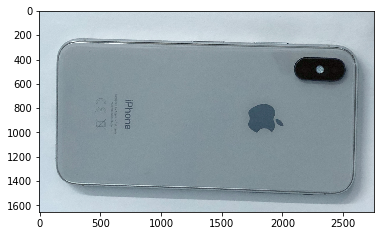

Pred: 0 ,label: 1


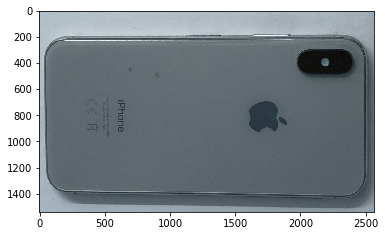

Pred: 0 ,label: 1


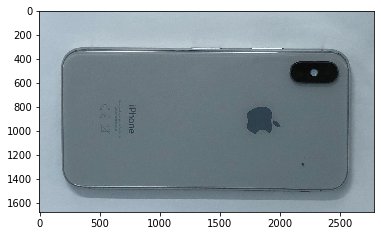

In [106]:
for i, x in enumerate(preds):
            if x!=Y_test[i]:
#             if Y_test[i]==1:
                print("Pred:",x, ",label:", Y_test[i])
                plt.imshow(np.squeeze(X_test[i], axis=-1), cmap='gray')
                image = cv2.imread(tes_X_dir[i], cv2.IMREAD_UNCHANGED)
                plt.imshow(image)
                plt.show()

In [66]:
# to show all the test images
for i in range(len(tes_X_dir)):
    print(tes_X_dir[i])
    print("Pred:",preds[i], ",label:", Y_test[i])
    plt.imshow(np.squeeze(X_test[i], axis=-1), cmap='gray')
    image = cv2.imread(tes_X_dir[i], cv2.IMREAD_UNCHANGED)
    plt.imshow(image)
    plt.show()
    

In [206]:
val_accuracies = [0.6201372742652893,
 0.7597253918647766,
 0.8077803254127502,
 0.8077803254127502,
 0.8077803254127502,
 0.8077803254127502,
0.8077803254127502,
 0.8077803254127502,
 0.8077803254127502,
 0.8277803254127502,
                  0.8277803254127502,
                  0.8277803254127502,
                  0.8277803254127502,
                  0.8277803254127502,
 0.9077803254127502,
 0.9077803254127502]

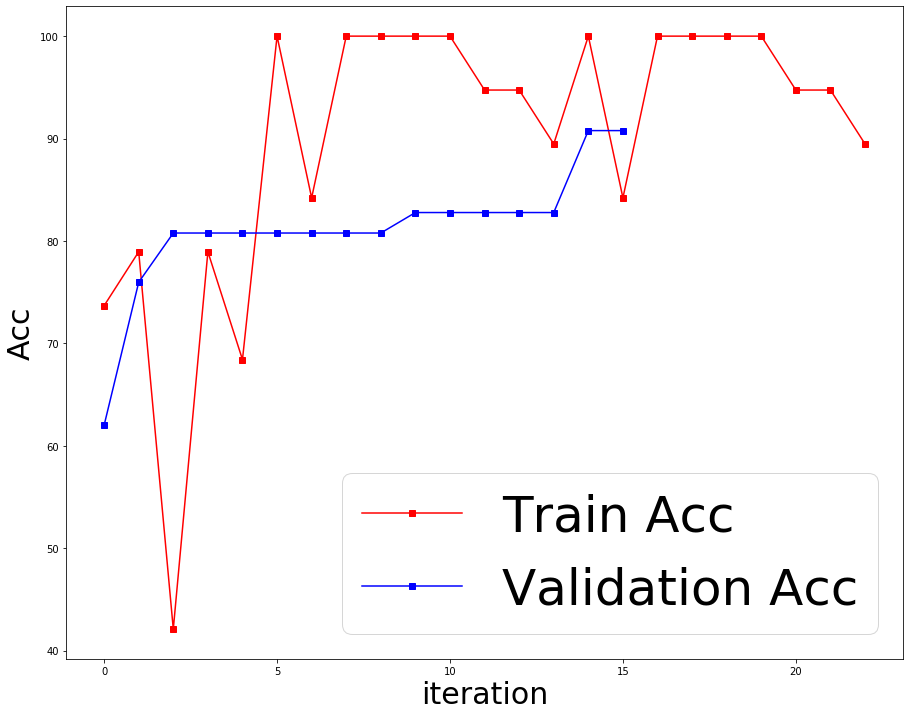

In [214]:
###################################
# Plot training curve             #
###################################
# plt.title('Training loss')
# loss_hist_ = losses[1::len(losses)//20]  # sparse the curve a bit
acc_hist_ = np.array(accuracies[1::len(accuracies)//20])*100
val_his = np.array(val_accuracies)*100

# loss_hist_ = losses
# acc_hist_ = np.array(accuracies)*100

# plt.plot(loss_hist_, '-o')
# plt.xlabel('iteration', size=30)
# plt.ylabel('loss',size=30)
# plt.gcf().set_size_inches(15, 12)

# plt.show()
# plt.close()

acc_hist_ = plt.plot(acc_hist_, '-s', color='red', label='Train Acc')
val_his = plt.plot(val_his, '-s', color='blue', label='Validation Acc')
plt.xlabel('iteration', size=30)
plt.ylabel('Acc',size=30)
plt.gcf().set_size_inches(15, 12)


plt.legend(fontsize=50 )
plt.show()

# conclusion
We can get up to ~ 95% accuracy and 96 f1-score in the test set using this simple model and just 5 epochs. To locate or annotate the area, we can use a similar approach as Grad-CAM paper (read [here](https://arxiv.org/pdf/1610.02391.pdf)) which highlights the active regions, this works because the active region is just the countors of the defection which give hint to the model to classify it as a defected one.  A more systematic hyper-parameter tunning like Bayesian optimization or Reinforcement learning (on top of the model) can give us better accuracy too. We have a paper on this in which we used a response surface methodology to tune the hyper-parameters of a deep learning model using Baysian like optimization approaches. We are about to submit it and could observe promising results there.

In [51]:
# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
# from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

In [129]:
tf.reset_default_graph()
sess = tf.Session()

# Restore the model using parameters dict
model = BaseModel()
variables = tf.global_variables()
param_dict = {}
for var in variables:
    var_name = var.name[:-2]
#     print('Loading {} from checkpoint. Name: {}'.format(var.name, var_name))
    param_dict[var_name] = var
saver = tf.train.Saver()
saver.restore(sess, "./app_dc.ckpt")

Loading conv1/w:0 from checkpoint. Name: conv1/w
Loading conv1/b:0 from checkpoint. Name: conv1/b
Loading conv1/batch_normalization/gamma:0 from checkpoint. Name: conv1/batch_normalization/gamma
Loading conv1/batch_normalization/beta:0 from checkpoint. Name: conv1/batch_normalization/beta
Loading conv1/batch_normalization/moving_mean:0 from checkpoint. Name: conv1/batch_normalization/moving_mean
Loading conv1/batch_normalization/moving_variance:0 from checkpoint. Name: conv1/batch_normalization/moving_variance
Loading conv2/w:0 from checkpoint. Name: conv2/w
Loading conv2/b:0 from checkpoint. Name: conv2/b
Loading conv2/batch_normalization/gamma:0 from checkpoint. Name: conv2/batch_normalization/gamma
Loading conv2/batch_normalization/beta:0 from checkpoint. Name: conv2/batch_normalization/beta
Loading conv2/batch_normalization/moving_mean:0 from checkpoint. Name: conv2/batch_normalization/moving_mean
Loading conv2/batch_normalization/moving_variance:0 from checkpoint. Name: conv2/batc

In [123]:
# test predict
# preds_ = []
# for i in range(len(tes_X_dir)):
#     img_path = tes_X_dir[i]
#     image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
#     image = image*1.0 / 127.5 - 1.0  # normalize
#     image = np.expand_dims(image, axis=-1) # for channel
#     image = np.expand_dims(image, axis=0) # for batch
# #     print(image.shape)

#     sess.run(tf.global_variables_initializer())
#     pred = model._predict(sess, image)
#     preds_.append(pred[0])
# preds_       

In [98]:
# img_path = "iphone/01.jpg"
img_path = "./03.jpg"
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
image = image*1.0 / 127.5 - 1.0  # normalize
image = np.expand_dims(image, axis=-1) # for channel
image = np.expand_dims(image, axis=0) # for batch
print(image.shape)

sess.run(tf.global_variables_initializer())
pred = model._predict(sess, image)
print(pred[0][0])

(1, 64, 64, 1)
1


In [132]:
class_idx = pred[0][0]
class_output = model.logits[:,class_idx]
last_conv_layer = model.conv3
grads = K.gradients(class_output, last_conv_layer)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.X], [pooled_grads, last_conv_layer[0]])
pooled_grads_value, conv_layer_output_value = iterate([image])
for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
save_heat = heatmap

In [156]:
heatmap = save_heat
# heatmap[5,20:25]=0.453
heatmap[:]=0
heatmap[3:5,6:10]=np.random.rand(2,4)
heatmap[5:7,6:10]=np.random.rand(2,4)
heatmap.shape

(16, 16)

In [157]:
img = cv2.imread(img_path)
# heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
img = cv2.resize(img, (2000, 2000))
heatmap = cv2.resize(heatmap, (2000, 2000))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
# cv2.imshow("Original", img)
# cv2.imshow("GradCam", superimposed_img)
# cv2.imwrite("./Original.jpg" ,img)
cv2.imwrite("./GradCam.jpg", superimposed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [160]:
from hyperopt import hp
from ray import tune

In [ ]:
space = {
    "lr": hp.loguniform("lr", 1e-10, 0.1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
    
}
hyperopt_search = HyperOptSearch(
    space, max_concurrent=2, reward_attr="mean_accuracy")

analysis = tune.run(
    model.train,
    num_samples=10,
    search_alg=hyperopt_search)

search_space = {
    "lr": tune.choice([0.001, 0.01, 0.1]),
    "momentum": tune.uniform(0.1, 0.9)
}
analysis = tune.run(train_mnist, config=search_space)


dfs = analysis.trial_dataframes

# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)